# Quasar Luminosity Function Model Comparison

Set up the appropriate paths.

In [2]:
import os, sys

current_file_dir = os.getcwd()
sys.path.insert(0, "".join([current_file_dir, "/../"]))
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

from config.program import data_dir, stylesheet

publication_dir = data_dir/"output"/"publication"

Import the appropriate packages.

In [3]:
import glob
import re
from collections import defaultdict

import corner
import h5py
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck15
from matplotlib.ticker import AutoMinorLocator

from horizonground.lumfunc_likelihood import LumFuncMeasurements
from horizonground.lumfunc_modeller import LumFuncModeller, quasar_PLE_lumfunc, quasar_hybrid_lumfunc

plt.style.use(stylesheet)

In [4]:
quantile_levels = [0.022750, 0.158655, 0.5, 0.841345, 0.977250]

## Quasar luminosity function models

In [5]:
PLE_model = LumFuncModeller.from_parameter_file(
    parameter_file=data_dir/"external"/"eBOSS_QSO_LF_PLE_model_fits.txt",
    model_lumfunc=quasar_PLE_lumfunc,
    brightness_variable='magnitude',
    threshold_value=22.5,
    cosmology=Planck15
)

In [6]:
hybrid_model = LumFuncModeller.from_parameter_file(
    parameter_file=data_dir/"external"/"eBOSS_QSO_LF_PLE+LEDE_model_fits.txt",
    model_lumfunc=quasar_hybrid_lumfunc,
    brightness_variable='magnitude',
    threshold_value=22.5,
    cosmology=Planck15
)

## Number density comparison

In [7]:
extracted_chain_files = glob.glob(
    "/".join([str(publication_dir), "dense_points", "density", "numden_z*"])
)

In [8]:
dense_redshifts = []
nbar_quantiles = defaultdict(list)
for chain_file in sorted(extracted_chain_files):
    dense_redshifts.append(float(
        re.search("_z(?P<redshift>.*?)_", chain_file).group('redshift')
    ))
    with h5py.File(chain_file, 'r') as chain_data:
        extracts = chain_data['extract/chain'][()]
        nbar_q = corner.quantile(extracts, q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        nbar_quantiles[sigma_level].append(nbar_q[sigma_level_idx])

In [9]:
discontinuity_pos = np.searchsorted(dense_redshifts, 2.2)

if dense_redshifts[discontinuity_pos] == 2.2:
    del dense_redshifts[discontinuity_pos]
    for sigma_level in nbar_quantiles:
        del nbar_quantiles[sigma_level][discontinuity_pos]

low_redshift_part = slice(0, discontinuity_pos)
high_redshift_part = slice(discontinuity_pos, None)

In [10]:
density_PLE = np.array([PLE_model.comoving_number_density(z) for z in dense_redshifts])
density_hybrid = np.array([hybrid_model.comoving_number_density(z) for z in dense_redshifts])

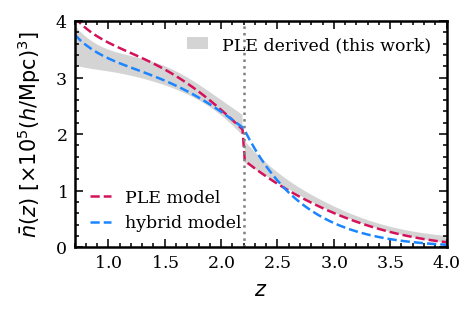

In [11]:
ALPHA = 0.5
SCALING = 10 ** 5

fig = plt.figure("comoving number density", figsize=(3.2, 2.), dpi=150)

ax = plt.subplot2grid((1, 1), (0, 0))

ax.plot(dense_redshifts, SCALING * density_PLE, ls='--', c='#D41159', label='PLE model')
ax.plot(dense_redshifts, SCALING * density_hybrid, ls='--', c='#1A85FF', label='hybrid model')
for idx, part in enumerate([low_redshift_part, high_redshift_part]):
    ax.fill_between(
        dense_redshifts[part], 
        SCALING * np.asarray(nbar_quantiles[-2][part]),
        SCALING * np.asarray(nbar_quantiles[2][part]),
        facecolor='0.67', alpha=ALPHA, zorder=1
    )

ax.axvline(x=2.2, ls=':', c='0.5')

ax.add_artist(plt.legend(
    [plt.Rectangle((0., 0.), 2., 1., ec=None, fc='0.67', alpha=ALPHA)],
    ['PLE derived (this work)'],
    loc='upper right'
))

ax.set_yticks(np.arange(0., 5., step=1.))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(min(dense_redshifts), max(dense_redshifts))
ax.set_ylim(0., 4.)
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$\bar{n}(z)\ [\times 10^5 (h/\mathrm{Mpc})^3]$", labelpad=6)
ax.legend(loc='lower left')

## Relativistic bias comparison

In [12]:
extracted_chain_files = glob.glob(
    "/".join([str(publication_dir), "dense_points", "bias", "relbias_z*"])
)

In [13]:
evolution_bias_quantiles = defaultdict(list)
magnification_bias_quantiles = defaultdict(list)
for chain_file in sorted(extracted_chain_files):
    with h5py.File(chain_file, 'r') as chain_data:
        extracts = chain_data['extract/chain'][()]
        evol_b_q = corner.quantile(extracts[:, 0], q=quantile_levels)
        magn_b_q = corner.quantile(extracts[:, 1], q=quantile_levels)
    for sigma_level_idx, sigma_level in enumerate([-2, -1, 0, 1, 2]):
        evolution_bias_quantiles[sigma_level].append(evol_b_q[sigma_level_idx])
        magnification_bias_quantiles[sigma_level].append(magn_b_q[sigma_level_idx])

In [14]:
evolution_bias_PLE = np.array([PLE_model.evolution_bias(z) for z in dense_redshifts])
evolution_bias_hybrid = np.array([hybrid_model.evolution_bias(z) for z in dense_redshifts])
magnification_bias_PLE = np.array([PLE_model.magnification_bias(z) for z in dense_redshifts])
magnification_bias_hybrid = np.array([hybrid_model.magnification_bias(z) for z in dense_redshifts])

Text(0, 0.5, '$s(z)$')

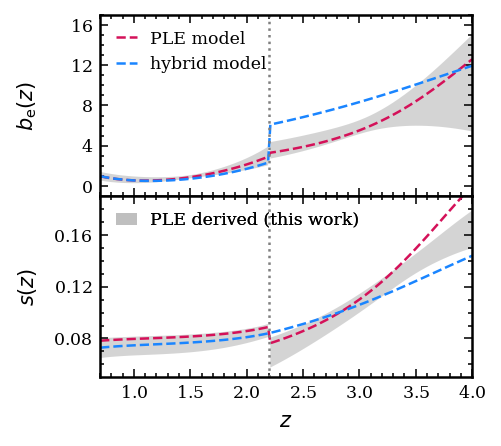

In [15]:
ALPHA = 0.5

fig = plt.figure("relativistic biases", figsize=(3.2, 3.2), dpi=150)

# Evolution bias

evolution = plt.subplot2grid((2, 1), (0, 0))

evolution.plot(dense_redshifts, evolution_bias_PLE, ls='--', c='#D41159', label='PLE model')
evolution.plot(dense_redshifts, evolution_bias_hybrid, ls='--', c='#1A85FF', label='hybrid model')
for part in [low_redshift_part, high_redshift_part]:
    evolution.fill_between(
        dense_redshifts[part],
        evolution_bias_quantiles[-2][part], evolution_bias_quantiles[2][part],
        facecolor='0.67', alpha=ALPHA, zorder=1
    )

evolution.axvline(x=2.2, ls=':', c='0.5')

evolution.legend(loc='upper left')
evolution.tick_params(axis='x', which='both', labelbottom=False)
evolution.set_yticks(np.arange(-4., 20., step=4.))
evolution.xaxis.set_minor_locator(AutoMinorLocator())
evolution.yaxis.set_minor_locator(AutoMinorLocator())
evolution.set_xlim(min(dense_redshifts), max(dense_redshifts))
evolution.set_ylim(-1., 17.)
evolution.set_ylabel(r"$b_\mathrm{e}(z)$", labelpad=15)

# Magnification bias

magnification = plt.subplot2grid((2, 1), (1, 0), sharex=evolution)

magnification.plot(dense_redshifts, magnification_bias_PLE, ls='--', c='#D41159', label='PLE model')
magnification.plot(dense_redshifts, magnification_bias_hybrid, ls='--', c='#1A85FF', label='hybrid model')
for part in [low_redshift_part, high_redshift_part]:
    magnification.fill_between(
        dense_redshifts[part],
        magnification_bias_quantiles[-2][part], magnification_bias_quantiles[2][part],
        facecolor='0.67', alpha=ALPHA, zorder=1
    )
    
magnification.axvline(x=2.2, ls=':', c='0.5')

magnification.add_artist(plt.legend(
    [plt.Rectangle((0., 0.), 2., 1., ec=None, fc='0.67', alpha=ALPHA)],
    ['PLE derived (this work)'],
    loc='upper left'
))
magnification.set_yticks(np.arange(0., 0.2, step=0.04))
magnification.yaxis.set_minor_locator(AutoMinorLocator())
magnification.set_ylim(0.05, 0.19)
magnification.set_xlabel(r"$z$", labelpad=5)
magnification.set_ylabel(r"$s(z)$", labelpad=7)